In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat

In [2]:
#getting the dataset
dataset = pd.read_csv('data.csv', header=0, index_col=0)
values = dataset.values

In [3]:
#function to convert series to supervised
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [4]:
#data preprocessing by normalizing
from sklearn.preprocessing import MinMaxScaler


In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [6]:
#converting data to supervised
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[6, 7, 8, 9, 10]], axis=1, inplace=True)
reframed.columns = ['el', 'az', 'airtemp', 'rh', 'press', 'ghi', 'fghi'] 

In [7]:
#splitting, 3 years of training and 2 years for testing
#scaledpd = DataFrame(scaled)
#scaledpd.dropna(inplace = True)
values = reframed.values
n_train_hours = 21424
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [8]:
# design network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD

In [9]:
from tensorflow.keras.optimizers import Adam

In [28]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [29]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(21424, 1, 6) (21424,) (60, 1, 6) (60,)


In [12]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.0009, beta_1=0.1, beta_2=0.999, epsilon=1e-05, amsgrad=False, name='Adam')
model.compile(loss='mae', optimizer=optimizer)

In [13]:
# fit network
history = model.fit(train_X, train_y, epochs=20, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 21424 samples, validate on 60 samples
Epoch 1/20
21424/21424 - 4s - loss: 0.0975 - val_loss: 0.0717
Epoch 2/20
21424/21424 - 2s - loss: 0.0740 - val_loss: 0.0723
Epoch 3/20
21424/21424 - 3s - loss: 0.0738 - val_loss: 0.0723
Epoch 4/20
21424/21424 - 3s - loss: 0.0737 - val_loss: 0.0722
Epoch 5/20
21424/21424 - 2s - loss: 0.0734 - val_loss: 0.0722
Epoch 6/20
21424/21424 - 2s - loss: 0.0733 - val_loss: 0.0719
Epoch 7/20
21424/21424 - 2s - loss: 0.0730 - val_loss: 0.0719
Epoch 8/20
21424/21424 - 2s - loss: 0.0727 - val_loss: 0.0716
Epoch 9/20
21424/21424 - 3s - loss: 0.0724 - val_loss: 0.0714
Epoch 10/20
21424/21424 - 2s - loss: 0.0719 - val_loss: 0.0711
Epoch 11/20
21424/21424 - 2s - loss: 0.0713 - val_loss: 0.0706
Epoch 12/20
21424/21424 - 2s - loss: 0.0702 - val_loss: 0.0698
Epoch 13/20
21424/21424 - 3s - loss: 0.0688 - val_loss: 0.0689
Epoch 14/20
21424/21424 - 2s - loss: 0.0672 - val_loss: 0.0677
Epoch 15/20
21424/21424 - 2s - loss: 0.0655 - val_loss: 0.0664
Epoch 16/20
21424

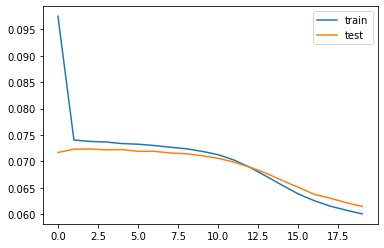

In [25]:
#plotting to check loss
from  matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [30]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

In [31]:
len(yhat)

60

In [16]:
# invert scaling for forecast
from numpy import concatenate


In [17]:
inv_yhat = concatenate((test_X[:, :-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]

In [18]:
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, :-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]

In [19]:
#error
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

#print('Individual RMSE: ')
#indrmse = [];
#for i in range(len(inv_y)):
 #   rms = sqrt(float(abs(inv_y[i]-inv_yhat[i])))
  #  indrmse.append(rms)
#pyplot.plot(indrmse)

Test RMSE: 85.323


In [32]:
len(dataset)

21924

In [37]:
datedata = dataset.index[-60:]

In [46]:
datedata[0].split(' ')[0]

'2016-12-27'

In [52]:
dateList = list()
for i,date in enumerate(datedata):
    dateList.append(datedata[i].split(' ')[0])

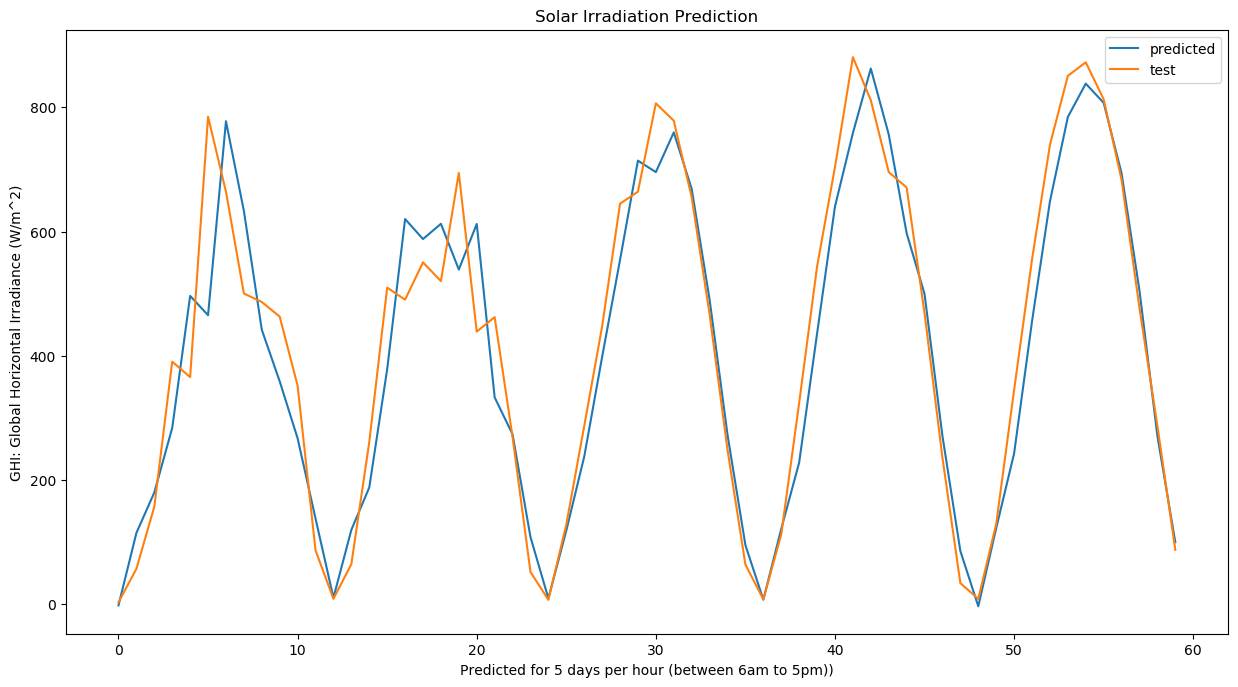

In [56]:
pyplot.figure(num=None, figsize=(15, 8), dpi=100, facecolor='w', edgecolor='k')
pyplot.title("Solar Irradiation Prediction")
pyplot.plot(inv_yhat, label='predicted')
pyplot.plot(inv_y, label='test')
pyplot.xlabel("Predicted for 5 days per hour (between 6am to 5pm))")
pyplot.ylabel("GHI: Global Horizontal Irradiance (W/m^2)")
image = pyplot.gcf()
pyplot.legend()
pyplot.show()

In [57]:
image.savefig('solarIrradiationPrediction.png')